## Deforestation Risk & Vulnerability Mapping

This analysis identifies areas with high vulnerability to future deforestation in Matale district using multiple criteria:
- Proximity to existing deforested areas
- Distance from forest edges
- Forest density and health (NDVI analysis)
- Historical deforestation trend patterns
- Accessibility factors (proximity to roads/development)

Deforestation Risk & Vulnerability Analysis - Matale District
⛅ Using cloud-masked Landsat data for improved accuracy
✓ AOI loaded: 11 polygon(s)
✓ Latest deforested file: Deforested_20241226.tif
✓ Latest NDVI file: NDVI_20241226.tif
✓ Deforested data shape: (2316, 1840)
  - Valid pixels: 3,810,596 (89.4%)
  - Masked pixels: 450,844 (10.6%)
✓ NDVI data shape: (2316, 1840)
  - Valid pixels: 3,810,596 (89.4%)
  - Masked pixels: 450,844 (10.6%)
✓ Distance calculation completed
  - Max distance: 810.2 pixels
  - Valid pixels: 3,810,596
✓ Forest vulnerability calculation completed
  - Valid pixels: 3,810,596
✓ Deforestation risk score calculation completed
  - Valid risk pixels: 3,798,100

✓ Risk zones classification completed
📊 Zone Distribution (excluding cloud-masked areas):
   Zone 0 (No Risk/Already Deforested): 12,496 pixels (0.3%)
   Zone 1 (Very Low Risk): 759,620 pixels (19.9%)
   Zone 2 (Low Risk): 759,626 pixels (19.9%)
   Zone 3 (Medium Risk): 759,651 pixels (19.9%)
   Zone 4 (H

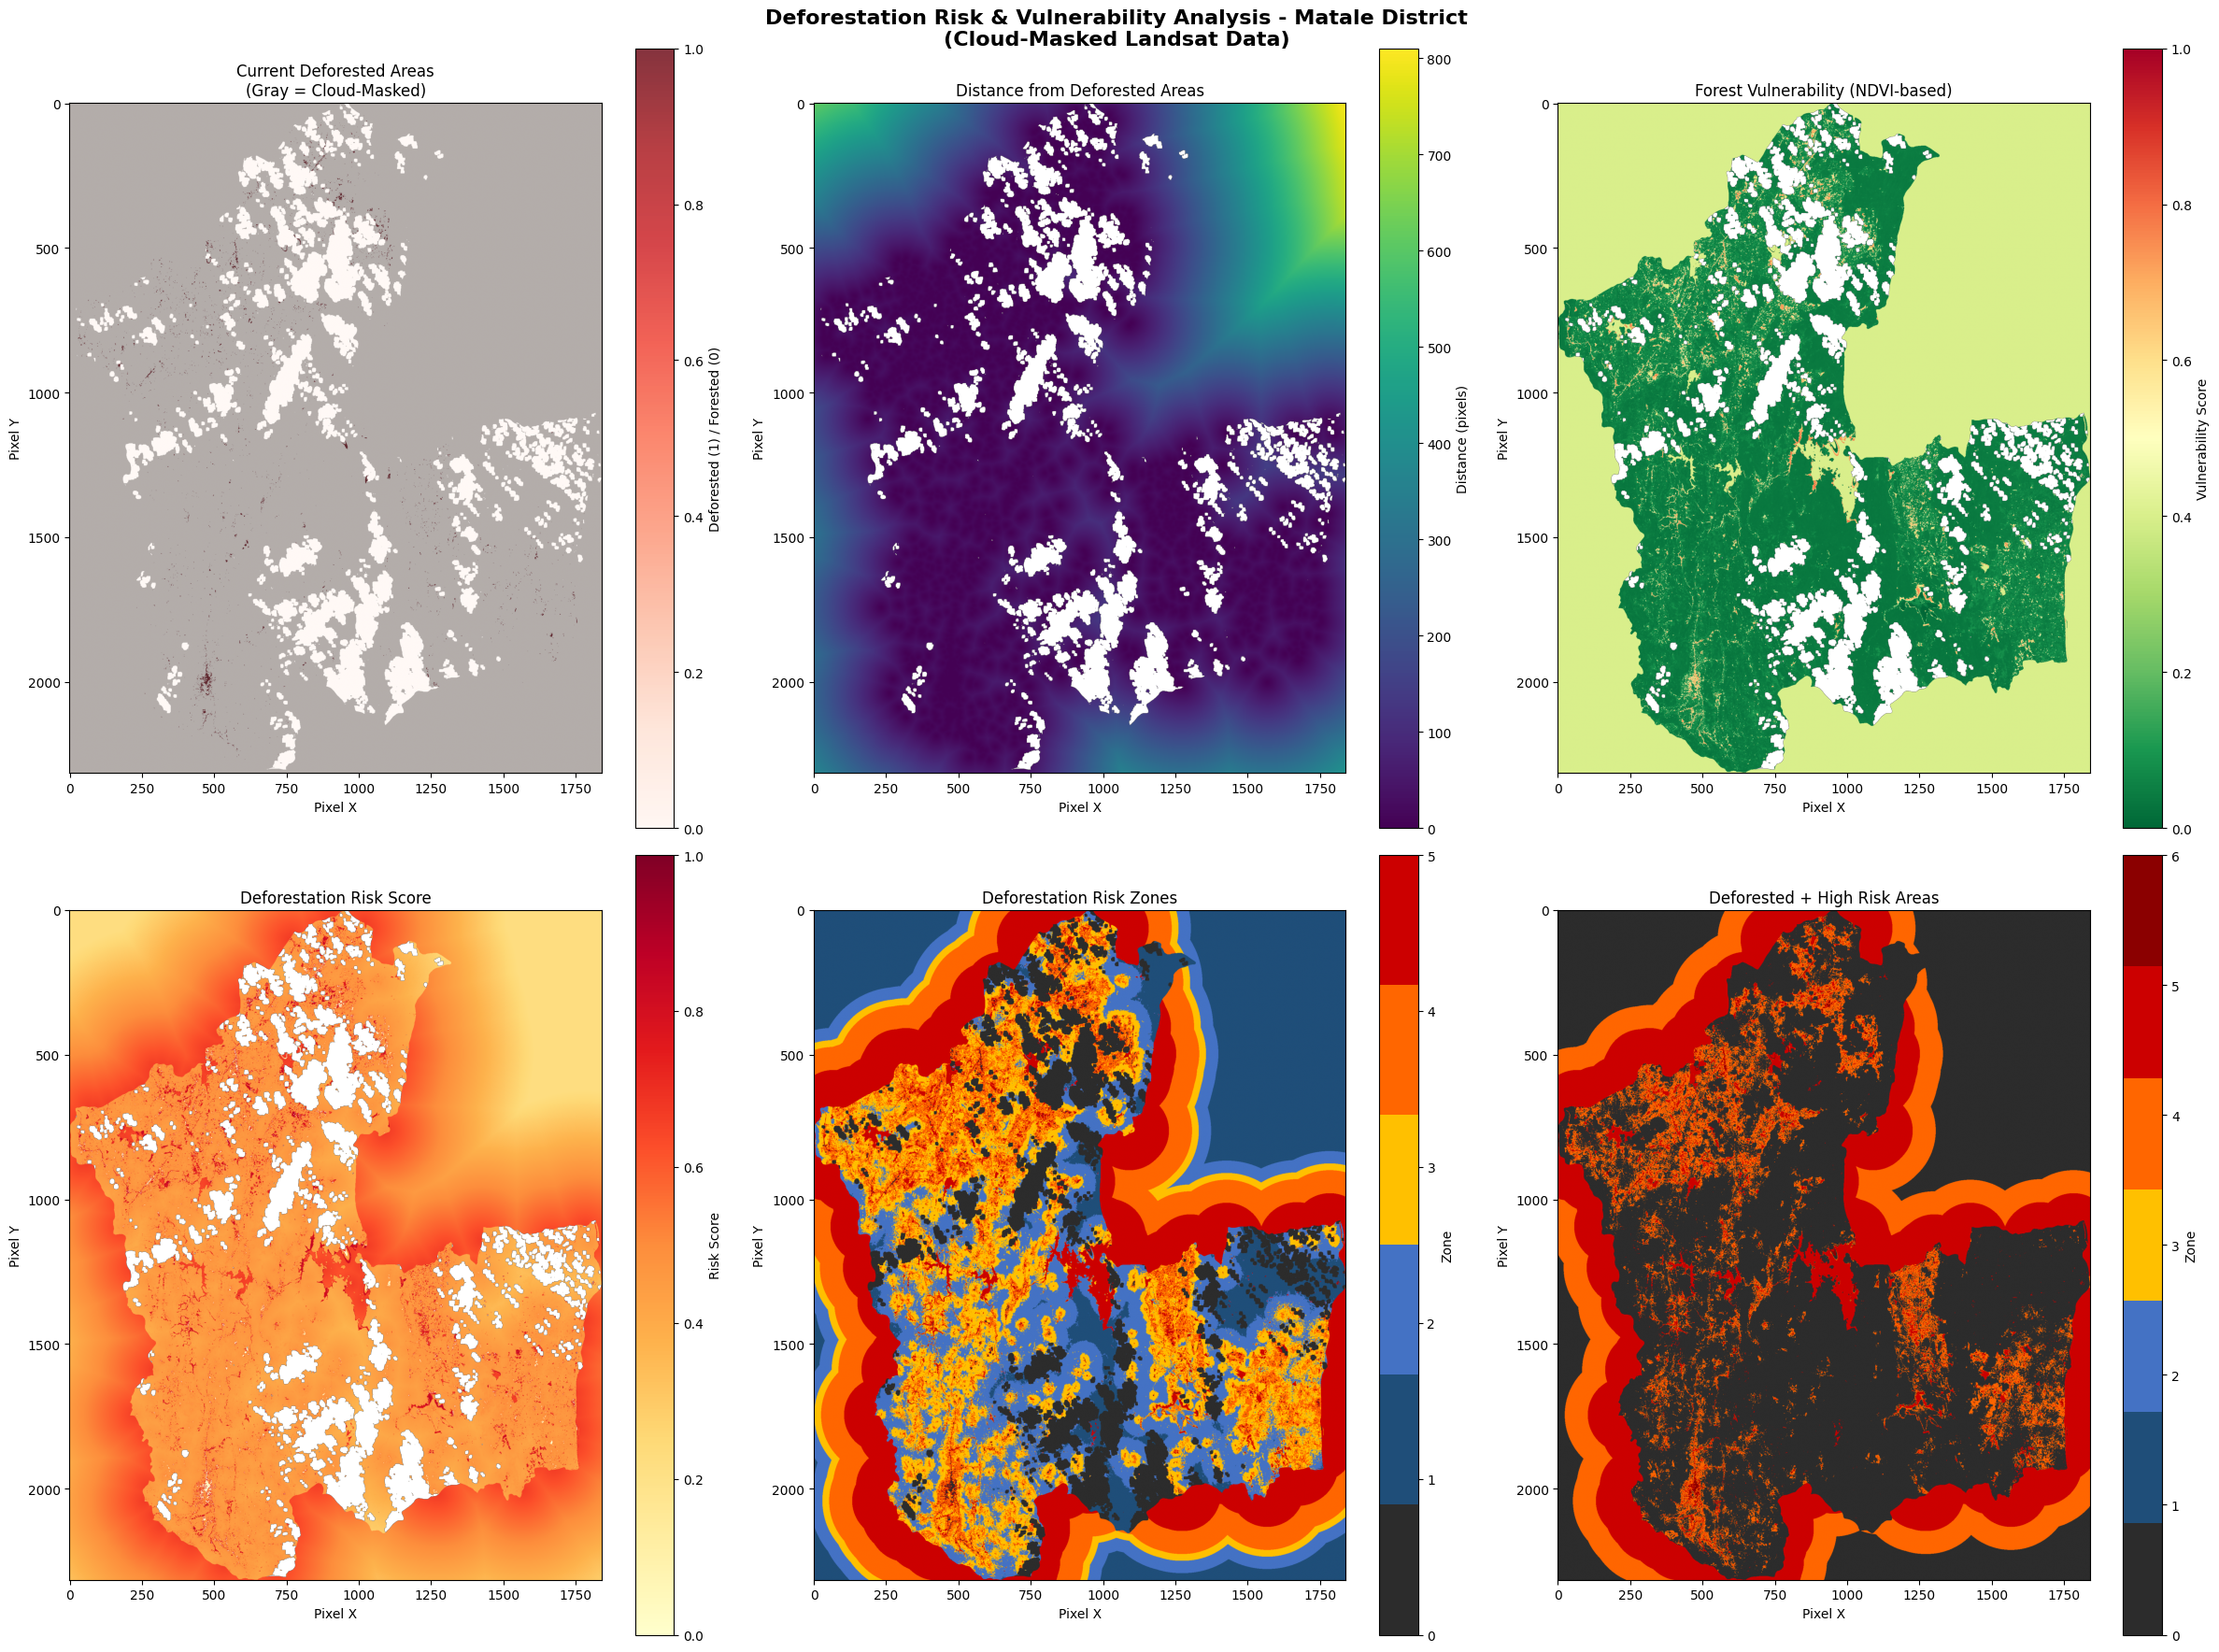


DEFORESTATION RISK ANALYSIS SUMMARY
(Based on cloud-masked Landsat data)

📊 Area Analysis (30m pixel resolution):
   Total area: 3835.30 km²
   Valid (cloud-free) area: 3429.54 km² (89.4%)
   Cloud-masked area: 405.76 km² (10.6%)

   Current deforested area: 11.25 km²
   High risk area (zones 4-5): 1367.28 km²
   Very high risk area (zone 5): 683.61 km²
   Remaining forest area: 3418.29 km²

⚠️  Risk ratio: 40.0% of remaining forest at high risk

📈 Detailed Zone Distribution (cloud-free areas only):
   No Risk/Already Deforested: 11.25 km² (0.3%)
   Very Low Risk: 683.66 km² (19.9%)
   Low Risk: 683.66 km² (19.9%)
   Medium Risk: 683.69 km² (19.9%)
   High Risk: 683.67 km² (19.9%)
   Very High Risk: 683.61 km² (19.9%)

CONSERVATION & PROTECTION RECOMMENDATIONS

🚨 PRIORITY PROTECTION AREAS:
   • Zone 5 (Very High Risk): 683.61 km²
   • Zone 4 (High Risk): 683.67 km²

🌳 CONSERVATION STRATEGY:
   1. Immediate protection for Zone 5 areas (highest priority)
   2. Implement monitoring syste

In [1]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# CONFIGURATION
BASE_DIR = r"D:\Satellite Image Processing\Deforestation_Matale"
AOI_PATH = os.path.join(BASE_DIR, "AOI", "matale_District_AOI.geojson")
PROCESSED_DIR = os.path.join(BASE_DIR, "Processed_Monthly")
OUTPUT_DIR = os.path.join(BASE_DIR, "Deforestation_Risk_Analysis")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Deforestation Risk & Vulnerability Analysis - Matale District")
print("=" * 60)
print("⛅ Using cloud-masked Landsat data for improved accuracy")
print("=" * 60)

# LOAD AOI
aoi = gpd.read_file(AOI_PATH)
print(f"✓ AOI loaded: {len(aoi)} polygon(s)")

# FIND LATEST DEFORESTED AND NDVI FILES
def find_latest_files():
    """Find the most recent deforested and NDVI files"""
    deforested_files = []
    ndvi_files = []
    
    if os.path.exists(PROCESSED_DIR):
        for file in os.listdir(PROCESSED_DIR):
            if file.startswith("Deforested_") and file.endswith(".tif"):
                deforested_files.append(file)
            elif file.startswith("NDVI_") and file.endswith(".tif"):
                ndvi_files.append(file)
    
    deforested_files.sort()
    ndvi_files.sort()
    
    latest_deforested = deforested_files[-1] if deforested_files else None
    latest_ndvi = ndvi_files[-1] if ndvi_files else None
    
    return latest_deforested, latest_ndvi

latest_deforested_file, latest_ndvi_file = find_latest_files()
print(f"✓ Latest deforested file: {latest_deforested_file}")
print(f"✓ Latest NDVI file: {latest_ndvi_file}")

# LOAD RASTER DATA WITH CLOUD MASK HANDLING
def load_raster_data(file_path):
    """Load raster data and return array with metadata, handling cloud-masked pixels"""
    with rasterio.open(file_path) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs
        bounds = src.bounds
        nodata = src.nodata
    
    # Handle different nodata representations
    if nodata is not None:
        data = data.astype(np.float32)
        data[data == nodata] = np.nan
    
    # For deforested rasters, 255 = cloud-masked pixels
    if "Deforested" in os.path.basename(file_path):
        data = data.astype(np.float32)
        data[data == 255] = np.nan
    
    return data, transform, crs, bounds

# Load latest deforested and NDVI data
deforested_path = os.path.join(PROCESSED_DIR, latest_deforested_file)
ndvi_path = os.path.join(PROCESSED_DIR, latest_ndvi_file)

deforested_data, transform, crs, bounds = load_raster_data(deforested_path)
ndvi_data, _, _, _ = load_raster_data(ndvi_path)

# Calculate cloud coverage
total_pixels = deforested_data.size
valid_deforested_pixels = np.sum(~np.isnan(deforested_data))
valid_ndvi_pixels = np.sum(~np.isnan(ndvi_data))
cloud_coverage_deforested = 100 * (1 - valid_deforested_pixels / total_pixels)
cloud_coverage_ndvi = 100 * (1 - valid_ndvi_pixels / total_pixels)

print(f"✓ Deforested data shape: {deforested_data.shape}")
print(f"  - Valid pixels: {valid_deforested_pixels:,} ({100-cloud_coverage_deforested:.1f}%)")
print(f"  - Masked pixels: {total_pixels - valid_deforested_pixels:,} ({cloud_coverage_deforested:.1f}%)")
print(f"✓ NDVI data shape: {ndvi_data.shape}")
print(f"  - Valid pixels: {valid_ndvi_pixels:,} ({100-cloud_coverage_ndvi:.1f}%)")
print(f"  - Masked pixels: {total_pixels - valid_ndvi_pixels:,} ({cloud_coverage_ndvi:.1f}%)")

# CALCULATE DISTANCE FROM DEFORESTED AREAS (CLOUD-AWARE)
def calculate_distance_from_deforested(deforested_array):
    """Calculate euclidean distance from existing deforested areas, handling cloud-masked pixels"""
    # Create binary deforested mask (excluding NaN/masked pixels)
    deforested_mask = np.nan_to_num(deforested_array, nan=0.0) == 1
    
    # Calculate distance transform
    distance = ndimage.distance_transform_edt(~deforested_mask)
    
    # Set distance to NaN where original data was masked
    distance = distance.astype(np.float32)
    distance[np.isnan(deforested_array)] = np.nan
    
    return distance

distance_from_deforested = calculate_distance_from_deforested(deforested_data)
valid_distance_pixels = np.sum(~np.isnan(distance_from_deforested))
print(f"✓ Distance calculation completed")
print(f"  - Max distance: {np.nanmax(distance_from_deforested):.1f} pixels")
print(f"  - Valid pixels: {valid_distance_pixels:,}")

# CALCULATE FOREST VULNERABILITY (CLOUD-AWARE)
def calculate_forest_vulnerability(ndvi_array):
    """Calculate forest vulnerability based on NDVI, handling cloud-masked pixels"""
    # Normalize NDVI to 0-1 scale
    ndvi_norm = np.clip(ndvi_array, -1, 1)
    
    # Calculate vulnerability (NaN values will propagate through calculations)
    vulnerability = np.zeros_like(ndvi_norm)
    
    # Dense forest (NDVI > 0.6): Lower vulnerability (0.2-0.4)
    vulnerability = np.where(ndvi_norm > 0.6, 0.3 * (1 - ndvi_norm), vulnerability)
    
    # Degraded forest (0.3 < NDVI <= 0.6): High vulnerability (0.5-0.8)
    vulnerability = np.where((ndvi_norm > 0.3) & (ndvi_norm <= 0.6), 
                            0.5 + 0.3 * (0.6 - ndvi_norm) / 0.3, vulnerability)
    
    # Sparse/cleared (NDVI <= 0.3): Moderate vulnerability
    vulnerability = np.where(ndvi_norm <= 0.3, 0.4, vulnerability)
    
    # Preserve NaN mask from original NDVI
    vulnerability[np.isnan(ndvi_array)] = np.nan
    
    return vulnerability

forest_vulnerability = calculate_forest_vulnerability(ndvi_data)
valid_vuln_pixels = np.sum(~np.isnan(forest_vulnerability))
print(f"✓ Forest vulnerability calculation completed")
print(f"  - Valid pixels: {valid_vuln_pixels:,}")

# CALCULATE DEFORESTATION RISK SCORE (CLOUD-AWARE)
def calculate_risk_score(distance_from_deforested, forest_vulnerability, deforested_mask):
    """Calculate overall deforestation risk score, handling cloud-masked pixels"""
    
    # Normalize distance (closer to deforested areas = higher risk)
    # Use nanpercentile to ignore masked pixels
    max_distance = np.nanpercentile(distance_from_deforested, 95)
    proximity_risk = 1 - np.clip(distance_from_deforested / max_distance, 0, 1)
    
    # Combine factors with weights
    weights = {
        'proximity': 0.45,      # 45% weight to proximity to deforested areas
        'vulnerability': 0.55   # 55% weight to forest vulnerability/degradation
    }
    
    risk_score = (
        weights['proximity'] * proximity_risk +
        weights['vulnerability'] * forest_vulnerability
    )
    
    # Exclude already deforested areas
    deforested_binary = np.nan_to_num(deforested_mask, nan=0.0) == 1
    risk_score = np.where(deforested_binary, 0, risk_score)
    
    # Preserve NaN mask (cloud-masked pixels have no risk score)
    risk_score[np.isnan(distance_from_deforested) | np.isnan(forest_vulnerability)] = np.nan
    
    return risk_score, proximity_risk

risk_score, proximity_risk = calculate_risk_score(
    distance_from_deforested, forest_vulnerability, deforested_data
)

valid_risk_pixels = np.sum(~np.isnan(risk_score) & (risk_score > 0))
print(f"✓ Deforestation risk score calculation completed")
print(f"  - Valid risk pixels: {valid_risk_pixels:,}")

# CLASSIFY RISK ZONES (CLOUD-AWARE)
def classify_risk_zones(risk_score, num_classes=5):
    """Classify areas into deforestation risk zones, handling cloud-masked pixels"""
    
    # Calculate percentile thresholds from valid (non-NaN, non-zero) risk scores
    valid_risk = risk_score[~np.isnan(risk_score) & (risk_score > 0)]
    
    if len(valid_risk) == 0:
        print("⚠ Warning: No valid risk scores to classify!")
        return np.zeros_like(risk_score, dtype=int), [0, 0, 0, 0]
    
    thresholds = [
        np.percentile(valid_risk, 20),
        np.percentile(valid_risk, 40),
        np.percentile(valid_risk, 60),
        np.percentile(valid_risk, 80)
    ]
    
    zones = np.zeros_like(risk_score, dtype=np.float32)
    zones = np.where(risk_score > thresholds[3], 5, zones)  # Very High Risk
    zones = np.where((risk_score > thresholds[2]) & (risk_score <= thresholds[3]), 4, zones)  # High Risk
    zones = np.where((risk_score > thresholds[1]) & (risk_score <= thresholds[2]), 3, zones)  # Medium Risk
    zones = np.where((risk_score > thresholds[0]) & (risk_score <= thresholds[1]), 2, zones)  # Low Risk
    zones = np.where((risk_score > 0) & (risk_score <= thresholds[0]), 1, zones)  # Very Low Risk
    
    # Preserve NaN mask for cloud-masked pixels
    zones[np.isnan(risk_score)] = np.nan
    
    return zones, thresholds

risk_zones, thresholds = classify_risk_zones(risk_score)

zone_labels = {
    0: 'No Risk/Already Deforested',
    1: 'Very Low Risk',
    2: 'Low Risk', 
    3: 'Medium Risk',
    4: 'High Risk',
    5: 'Very High Risk'
}

print("\n✓ Risk zones classification completed")
print("📊 Zone Distribution (excluding cloud-masked areas):")
valid_zone_pixels = ~np.isnan(risk_zones)
for i, label in zone_labels.items():
    count = np.sum(np.nan_to_num(risk_zones, nan=-1) == i)
    percentage = (count / np.sum(valid_zone_pixels)) * 100 if np.sum(valid_zone_pixels) > 0 else 0
    print(f"   Zone {i} ({label}): {count:,} pixels ({percentage:.1f}%)")

cloud_masked_pixels = np.sum(np.isnan(risk_zones))
print(f"   Cloud-masked pixels: {cloud_masked_pixels:,} ({cloud_masked_pixels/risk_zones.size*100:.1f}%)")

# SAVE RESULTS TO GEOTIFF WITH NODATA HANDLING
def save_raster(array, output_path, transform, crs, nodata_value=None):
    """Save numpy array as GeoTIFF with proper nodata handling"""
    
    # Determine nodata value based on dtype
    if nodata_value is None:
        if array.dtype in [np.float32, np.float64]:
            nodata_value = np.nan
        elif array.dtype == np.uint8:
            nodata_value = 255
        else:
            nodata_value = -9999
    
    with rasterio.open(
        output_path, 'w',
        driver='GTiff',
        height=array.shape[0],
        width=array.shape[1],
        count=1,
        dtype=array.dtype,
        crs=crs,
        transform=transform,
        nodata=nodata_value
    ) as dst:
        dst.write(array, 1)

# Save all outputs with proper nodata values
print("\n💾 Saving outputs...")
save_raster(risk_score.astype(np.float32), 
           os.path.join(OUTPUT_DIR, "deforestation_risk_score.tif"), transform, crs, nodata_value=np.nan)
save_raster(risk_zones.astype(np.float32), 
           os.path.join(OUTPUT_DIR, "deforestation_risk_zones.tif"), transform, crs, nodata_value=np.nan)
save_raster(proximity_risk.astype(np.float32), 
           os.path.join(OUTPUT_DIR, "proximity_risk.tif"), transform, crs, nodata_value=np.nan)
save_raster(forest_vulnerability.astype(np.float32), 
           os.path.join(OUTPUT_DIR, "forest_vulnerability.tif"), transform, crs, nodata_value=np.nan)

print("✓ Results saved to GeoTIFF files (with cloud mask preserved)")

# VISUALIZATION WITH CLOUD MASK OVERLAY
fig, axes = plt.subplots(2, 3, figsize=(24, 18))
fig.suptitle('Deforestation Risk & Vulnerability Analysis - Matale District\n(Cloud-Masked Landsat Data)', 
             fontsize=16, fontweight='bold')

# Create cloud mask for visualization
cloud_mask = np.isnan(risk_zones)

# 1. Current Deforested Areas
deforested_plot = np.nan_to_num(deforested_data, nan=0)
im1 = axes[0, 0].imshow(deforested_plot, cmap='Reds', alpha=0.8)
# Overlay cloud mask
axes[0, 0].imshow(cloud_mask, cmap='gray', alpha=0.3)
axes[0, 0].set_title('Current Deforested Areas\n(Gray = Cloud-Masked)')
axes[0, 0].set_xlabel('Pixel X')
axes[0, 0].set_ylabel('Pixel Y')
plt.colorbar(im1, ax=axes[0, 0], label='Deforested (1) / Forested (0)')

# 2. Distance from Deforested Areas
im2 = axes[0, 1].imshow(distance_from_deforested, cmap='viridis')
axes[0, 1].set_title('Distance from Deforested Areas')
axes[0, 1].set_xlabel('Pixel X')
axes[0, 1].set_ylabel('Pixel Y')
plt.colorbar(im2, ax=axes[0, 1], label='Distance (pixels)')

# 3. Forest Vulnerability
im3 = axes[0, 2].imshow(forest_vulnerability, cmap='RdYlGn_r', vmin=0, vmax=1)
axes[0, 2].set_title('Forest Vulnerability (NDVI-based)')
axes[0, 2].set_xlabel('Pixel X')
axes[0, 2].set_ylabel('Pixel Y')
plt.colorbar(im3, ax=axes[0, 2], label='Vulnerability Score')

# 4. Deforestation Risk Score
im4 = axes[1, 0].imshow(risk_score, cmap='YlOrRd', vmin=0, vmax=1)
axes[1, 0].set_title('Deforestation Risk Score')
axes[1, 0].set_xlabel('Pixel X')
axes[1, 0].set_ylabel('Pixel Y')
plt.colorbar(im4, ax=axes[1, 0], label='Risk Score')

# 5. Risk Zones
colors = ['#2c2c2c', '#1f4e79', '#4472c4', '#ffc000', '#ff6600', '#cc0000']
risk_zones_plot = np.nan_to_num(risk_zones, nan=0)
im5 = axes[1, 1].imshow(risk_zones_plot, cmap=plt.matplotlib.colors.ListedColormap(colors))
axes[1, 1].set_title('Deforestation Risk Zones')
axes[1, 1].set_xlabel('Pixel X')
axes[1, 1].set_ylabel('Pixel Y')
cbar5 = plt.colorbar(im5, ax=axes[1, 1], label='Zone')
cbar5.set_ticks(range(6))
cbar5.set_ticklabels([f"{i}" for i in range(6)])

# 6. Combined View (Deforested + High Risk)
combined = np.zeros_like(risk_zones_plot)
deforested_binary = np.nan_to_num(deforested_data, nan=0) == 1
combined = np.where(deforested_binary, 6, combined)  # Existing deforested in dark red
combined = np.where((risk_zones_plot >= 4) & (~deforested_binary), risk_zones_plot, combined)  # High risk areas

im6 = axes[1, 2].imshow(combined, cmap=plt.matplotlib.colors.ListedColormap(colors + ['#8b0000']))
axes[1, 2].set_title('Deforested + High Risk Areas')
axes[1, 2].set_xlabel('Pixel X')
axes[1, 2].set_ylabel('Pixel Y')
plt.colorbar(im6, ax=axes[1, 2], label='Zone')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "deforestation_risk_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

# STATISTICS AND SUMMARY (CLOUD-AWARE)
print("\n" + "="*60)
print("DEFORESTATION RISK ANALYSIS SUMMARY")
print("(Based on cloud-masked Landsat data)")
print("="*60)

# Calculate areas (assuming 30m pixel resolution)
pixel_area_km2 = (30 * 30) / 1e6  # 30m x 30m pixel in km²

print(f"\n📊 Area Analysis (30m pixel resolution):")
total_area = risk_zones.size * pixel_area_km2
valid_area = np.sum(~np.isnan(risk_zones)) * pixel_area_km2
masked_area = np.sum(np.isnan(risk_zones)) * pixel_area_km2

print(f"   Total area: {total_area:.2f} km²")
print(f"   Valid (cloud-free) area: {valid_area:.2f} km² ({valid_area/total_area*100:.1f}%)")
print(f"   Cloud-masked area: {masked_area:.2f} km² ({masked_area/total_area*100:.1f}%)")

current_deforested_area = np.sum(np.nan_to_num(deforested_data, nan=0) == 1) * pixel_area_km2
print(f"\n   Current deforested area: {current_deforested_area:.2f} km²")

high_risk_area = np.sum(np.nan_to_num(risk_zones, nan=0) >= 4) * pixel_area_km2
print(f"   High risk area (zones 4-5): {high_risk_area:.2f} km²")

very_high_risk_area = np.sum(np.nan_to_num(risk_zones, nan=0) == 5) * pixel_area_km2
print(f"   Very high risk area (zone 5): {very_high_risk_area:.2f} km²")

forest_area = (np.sum(np.nan_to_num(deforested_data, nan=0) == 0) - masked_area/pixel_area_km2) * pixel_area_km2
print(f"   Remaining forest area: {forest_area:.2f} km²")

if forest_area > 0:
    print(f"\n⚠️  Risk ratio: {high_risk_area/forest_area*100:.1f}% of remaining forest at high risk")
else:
    print("\n⚠️  Cannot calculate risk ratio (no valid forest area)")

# Zone distribution
print(f"\n📈 Detailed Zone Distribution (cloud-free areas only):")
valid_pixels = np.sum(~np.isnan(risk_zones))
for zone_id, label in zone_labels.items():
    count = np.sum(np.nan_to_num(risk_zones, nan=-1) == zone_id)
    area = count * pixel_area_km2
    percentage = (count / valid_pixels) * 100 if valid_pixels > 0 else 0
    print(f"   {label}: {area:.2f} km² ({percentage:.1f}%)")

# CONSERVATION RECOMMENDATIONS
print(f"\n" + "="*60)
print("CONSERVATION & PROTECTION RECOMMENDATIONS")
print("="*60)

print(f"""
🚨 PRIORITY PROTECTION AREAS:
   • Zone 5 (Very High Risk): {very_high_risk_area:.2f} km²
   • Zone 4 (High Risk): {np.sum(np.nan_to_num(risk_zones, nan=0) == 4) * pixel_area_km2:.2f} km²

🌳 CONSERVATION STRATEGY:
   1. Immediate protection for Zone 5 areas (highest priority)
   2. Implement monitoring systems for Zone 4 areas
   3. Community engagement in Zones 3-4 for sustainable practices
   4. Reforestation programs near deforested edges

🛡️ PROTECTION MEASURES:
   • Deploy forest rangers to high-risk zones
   • Establish buffer zones around protected areas
   • Monitor degraded forest areas (medium NDVI) closely
   • Restrict access/development in very high-risk zones

📊 FOREST STATUS:
   • Current deforested: {current_deforested_area:.2f} km²
   • High risk forest: {high_risk_area:.2f} km²
   • At-risk percentage: {high_risk_area/forest_area*100:.1f}% of remaining forest

🎯 INTERVENTION PRIORITIES:
   1. Focus on forest edges (proximity to deforested areas)
   2. Protect degraded forests showing decline
   3. Strengthen enforcement in high-risk corridors
   4. Promote sustainable land use alternatives

⛅ DATA QUALITY NOTES:
   • Analysis based on cloud-masked Landsat data
   • Cloud-masked pixels ({masked_area:.2f} km²) excluded from risk calculation
   • Risk estimates are for cloud-free areas only
   • Consider temporal compositing for cloud-heavy regions
""")

print("\n✅ Deforestation risk analysis completed!")
print(f"📁 Results saved to: {OUTPUT_DIR}")
print("\nFiles generated:")
print("• deforestation_risk_analysis.png - Comprehensive visualization")
print("• deforestation_risk_score.tif - Risk scores (NaN = cloud-masked)")
print("• deforestation_risk_zones.tif - Classified risk zones (NaN = cloud-masked)")
print("• proximity_risk.tif - Proximity to deforested areas (NaN = cloud-masked)")
print("• forest_vulnerability.tif - Forest vulnerability assessment (NaN = cloud-masked)")

## How to Open and View GeoTIFF Risk Maps

The analysis generates several GeoTIFF files showing deforestation risk that can be opened in different ways:

🗺️ VIEWING DEFORESTATION RISK MAPS


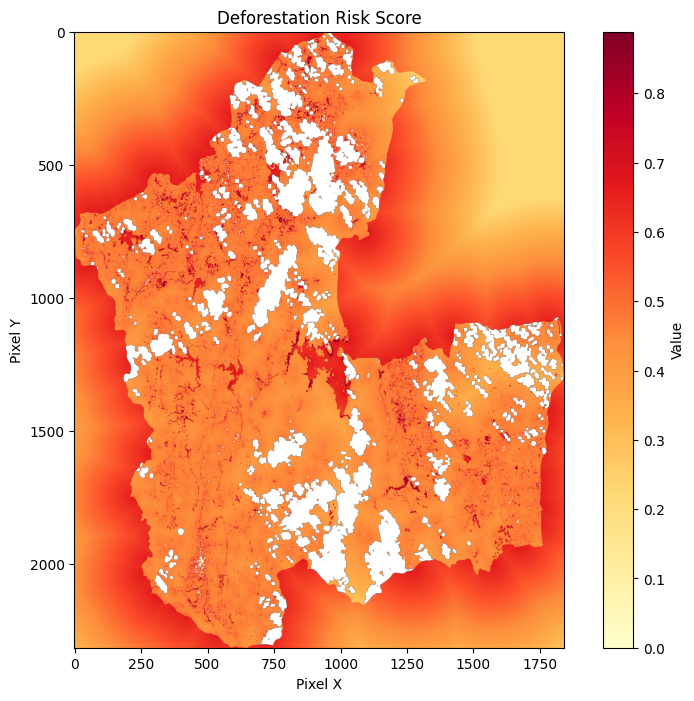

File: deforestation_risk_score.tif
Shape: (2316, 1840)
Data type: float32
Min value: 0.000
Max value: 0.889
----------------------------------------


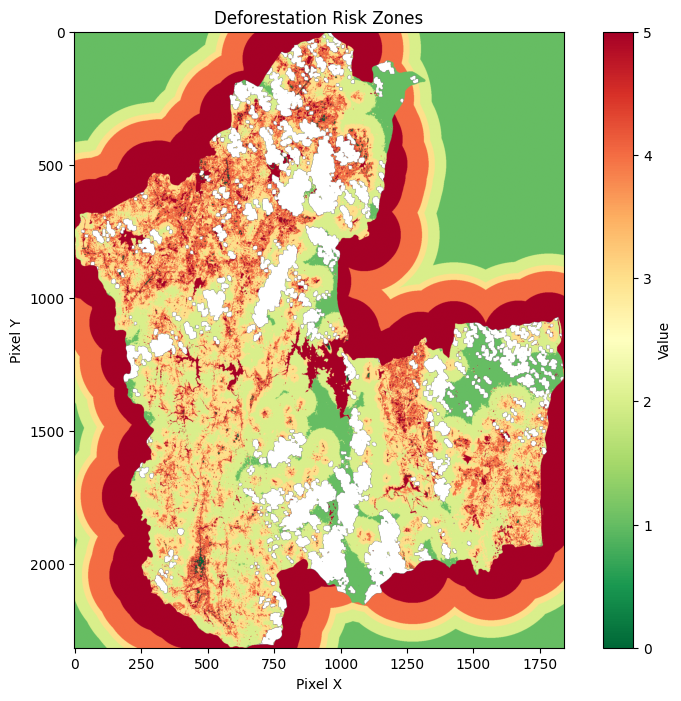

File: deforestation_risk_zones.tif
Shape: (2316, 1840)
Data type: float32
Min value: 0.000
Max value: 5.000
----------------------------------------


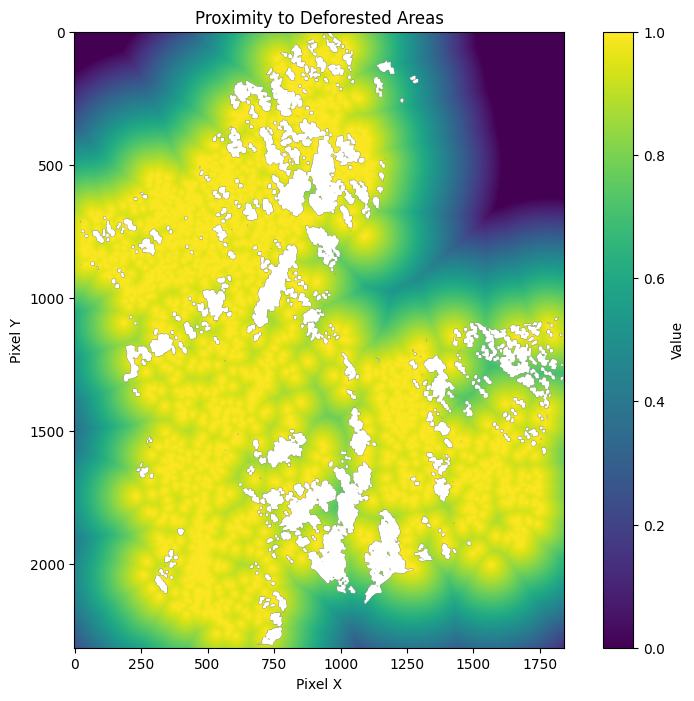

File: proximity_risk.tif
Shape: (2316, 1840)
Data type: float32
Min value: 0.000
Max value: 1.000
----------------------------------------


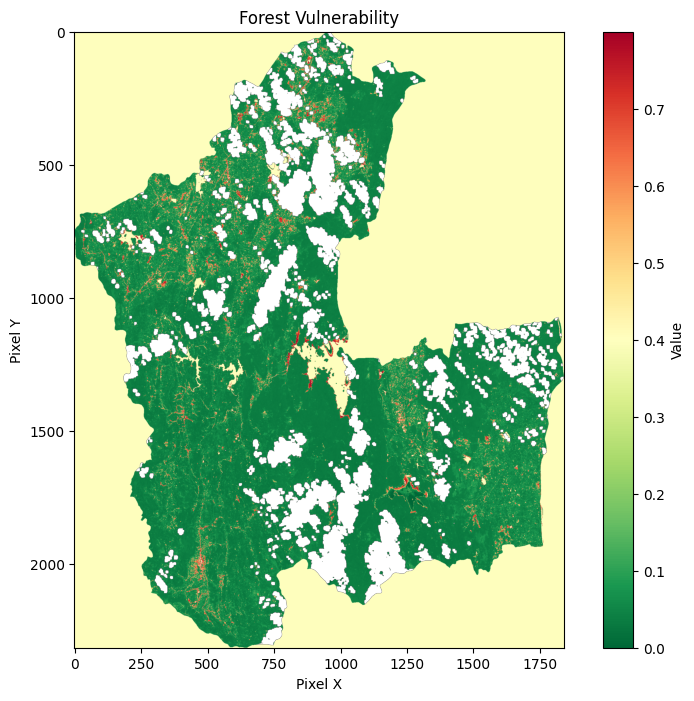

File: forest_vulnerability.tif
Shape: (2316, 1840)
Data type: float32
Min value: 0.000
Max value: 0.800
----------------------------------------


In [2]:
# METHOD 1: Using Python/Jupyter (Best for analysis)
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the output directory
OUTPUT_DIR = r"D:\Satellite Image Processing\Deforestation_Matale\Deforestation_Risk_Analysis"

# Function to display TIF files
def display_tif(file_path, title="", cmap='viridis'):
    """Display a TIF file with matplotlib"""
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            data = src.read(1)
            
        plt.figure(figsize=(10, 8))
        plt.imshow(data, cmap=cmap)
        plt.colorbar(label='Value')
        plt.title(title)
        plt.xlabel('Pixel X')
        plt.ylabel('Pixel Y')
        plt.show()
        
        print(f"File: {os.path.basename(file_path)}")
        print(f"Shape: {data.shape}")
        print(f"Data type: {data.dtype}")
        print(f"Min value: {np.nanmin(data):.3f}")
        print(f"Max value: {np.nanmax(data):.3f}")
        print("-" * 40)
    else:
        print(f"File not found: {file_path}")

# Display all generated TIF files
tif_files = [
    ("deforestation_risk_score.tif", "Deforestation Risk Score", "YlOrRd"),
    ("deforestation_risk_zones.tif", "Deforestation Risk Zones", "RdYlGn_r"),
    ("proximity_risk.tif", "Proximity to Deforested Areas", "viridis"),
    ("forest_vulnerability.tif", "Forest Vulnerability", "RdYlGn_r")
]

print("🗺️ VIEWING DEFORESTATION RISK MAPS")
print("=" * 50)

for filename, title, colormap in tif_files:
    file_path = os.path.join(OUTPUT_DIR, filename)
    display_tif(file_path, title, colormap)

In [3]:
def load_tif_with_coordinates(file_path):
    """Load TIF file with proper geographic coordinates"""
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            data = src.read(1)
            transform = src.transform
            crs = src.crs
            bounds = src.bounds
            
            print(f"📍 FILE: {os.path.basename(file_path)}")
            print(f"   Shape: {data.shape}")
            print(f"   CRS: {crs}")
            print(f"   Bounds: {bounds}")
            print(f"   Transform: {transform}")
            print(f"   Data range: {np.nanmin(data):.3f} to {np.nanmax(data):.3f}")
            print("-" * 50)
            
            return data, transform, crs, bounds
    else:
        print(f"File not found: {file_path}")
        return None, None, None, None

# Load all TIF files with geographic information
print("📍 DEFORESTATION RISK MAPS - GEOGRAPHIC INFORMATION")
print("=" * 50)

for filename, _, _ in tif_files:
    file_path = os.path.join(OUTPUT_DIR, filename)
    load_tif_with_coordinates(file_path)

📍 DEFORESTATION RISK MAPS - GEOGRAPHIC INFORMATION
📍 FILE: deforestation_risk_score.tif
   Shape: (2316, 1840)
   CRS: EPSG:32644
   Bounds: BoundingBox(left=444225.0, bottom=816195.0, right=499425.0, top=885675.0)
   Transform: | 30.00, 0.00, 444225.00|
| 0.00,-30.00, 885675.00|
| 0.00, 0.00, 1.00|
   Data range: 0.000 to 0.889
--------------------------------------------------
📍 FILE: deforestation_risk_zones.tif
   Shape: (2316, 1840)
   CRS: EPSG:32644
   Bounds: BoundingBox(left=444225.0, bottom=816195.0, right=499425.0, top=885675.0)
   Transform: | 30.00, 0.00, 444225.00|
| 0.00,-30.00, 885675.00|
| 0.00, 0.00, 1.00|
   Data range: 0.000 to 5.000
--------------------------------------------------
📍 FILE: proximity_risk.tif
   Shape: (2316, 1840)
   CRS: EPSG:32644
   Bounds: BoundingBox(left=444225.0, bottom=816195.0, right=499425.0, top=885675.0)
   Transform: | 30.00, 0.00, 444225.00|
| 0.00,-30.00, 885675.00|
| 0.00, 0.00, 1.00|
   Data range: 0.000 to 1.000
-----------------